In [1]:
import numpy as np
import pandas as pd 
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import thinkstats2
import thinkplot

pd.options.display.float_format = '{:.2f}'.format # change the display format of numbers

In [2]:
saffronart_df = pd.read_csv('updated_saffronart_dataset.csv') 

# change the dates to Pandas datetime objects:
saffronart_df['auction_date'] = pd.to_datetime(saffronart_df['auction_date'])
saffronart_df['birth_date'] = pd.to_datetime(saffronart_df['birth_date'])
saffronart_df['death_date'] = pd.to_datetime(saffronart_df['death_date'])

saffronart_df.head(5)

,artist,birth_date,birth_place,death_date,artist_age,title,winning_bid,low_est,high_est,auction_date,category,style,size,medium,area_or_vol,auction_dt_age
0,akhilesh,1956-01-01,Indore,NaT,63.00,Divine Conversation,9000.00,5000.00,7000.00,2019-06-01,painting,abstract,71.5 x 71.5 in,acrylic on canvas,5112.25,63.00
1,akhilesh,1956-01-01,Indore,NaT,63.00,In search of Untitled forms -II,1120.00,5000.00,6670.00,2013-11-01,painting,abstract,32.5 x 44 in,acrylic on canvas,1430.00,57.00
2,akhilesh,1956-01-01,Indore,NaT,63.00,In Search of Untitled Lines,6186.00,6900.00,8625.00,2013-08-01,painting,NaN,47 x 47 in,acrylic on canvas,2209.00,57.00
3,akhilesh,1956-01-01,Indore,NaT,63.00,Magadhi,2400.00,5770.00,7695.00,2013-02-01,painting,abstract,33 x 44.5 in,acrylic on canvas,1468.50,57.00
4,akhilesh,1956-01-01,Indore,NaT,63.00,Untitled,2942.00,6735.00,8655.00,2013-02-01,painting,abstract,40 x 40 in,acrylic on canvas,1600.00,57.00


---
# Price and Artist's Age

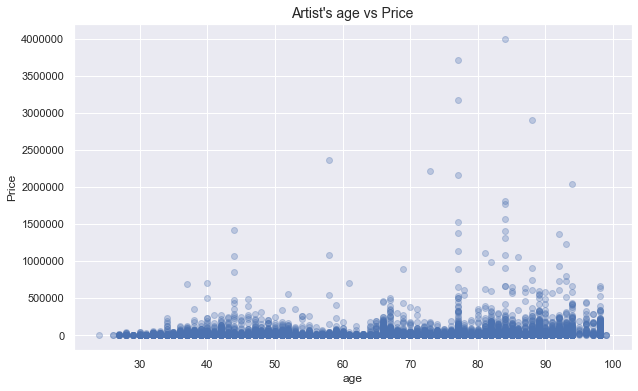

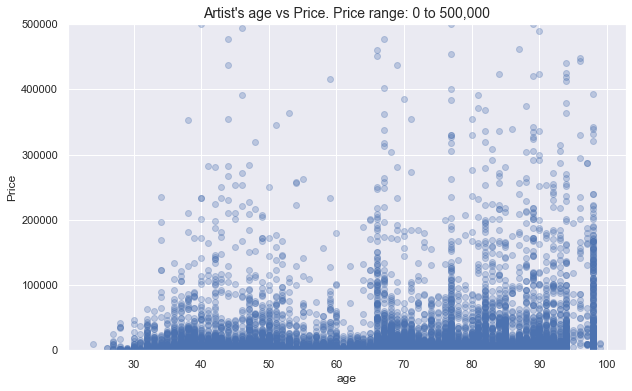

In [3]:
# Draw Scatter Plot:
price = saffronart_df.winning_bid 
age = saffronart_df.auction_dt_age # the artist's age at the time of the auction

def scatter_price(x_values, price, x_name, price_lim=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, price, alpha=0.3)
    plt.ylim(price_lim)
    
    plt.xlabel(x_name, fontsize=12)
    plt.ylabel('Price', fontsize=12)
    
    try:
        plt.title("Artist's age vs Price. Price range: {:,} to {:,}".format(price_lim[0], price_lim[1]), fontsize=14)
    except TypeError: # if price_lim is not given
        plt.title("Artist's age vs Price", fontsize=14)
    
scatter_price(age, price, 'age')
scatter_price(age, price, 'age', price_lim=(0, 500000))

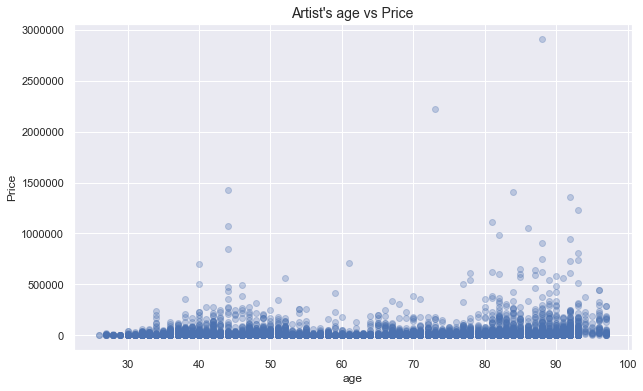

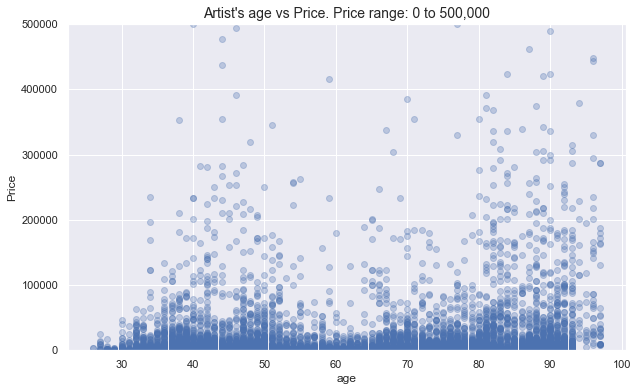

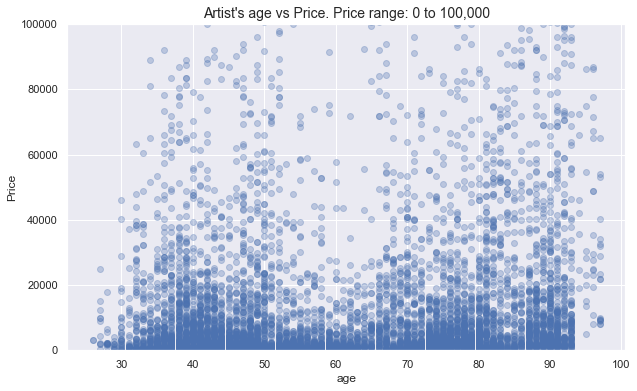

In [4]:
alive = saffronart_df.loc[saffronart_df.auction_dt_age < saffronart_df.artist_age].copy()

alive_price = alive.winning_bid
alive_age = alive.auction_dt_age

scatter_price(alive_age, alive_price, 'age')
scatter_price(alive_age, alive_price, 'age', price_lim=(0, 500000))
scatter_price(alive_age, alive_price, 'age', price_lim=(0, 100000))

In [5]:
def price_percentiles_by_gr(df, x_bins, x_var_name, percentiles_list=[75, 50, 25]):
    plt.figure(figsize=(10, 6)) 

    indices = np.digitize(df[x_var_name], x_bins) 
    groups = df.groupby(indices) 

    mean_xs = [group[x_var_name].mean() for i, group in groups]
    price_cdfs = [thinkstats2.Cdf(group.winning_bid) for i, group in groups]

    for percent in percentiles_list: 
        price_percentiles = [cdf.Percentile(percent) for cdf in price_cdfs] 
        label = '{}th'.format(percent) 
        plt.plot(mean_xs, price_percentiles, label=label, linewidth = 3)
        
    plt.xlabel(x_var_name)
    plt.ylabel('price')
    plt.title('Price percentiles by groups of {}'.format(x_var_name), size=14)
    
    plt.legend()

In [6]:
min_age = alive.auction_dt_age.min()
print("Min alive age: ", min_age)

max_age = alive.auction_dt_age.max()
print("Max alive age: ", max_age)

Min alive age:  26.0
Max alive age:  97.0


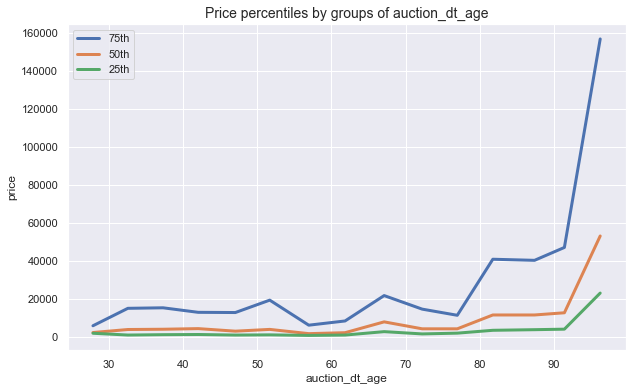

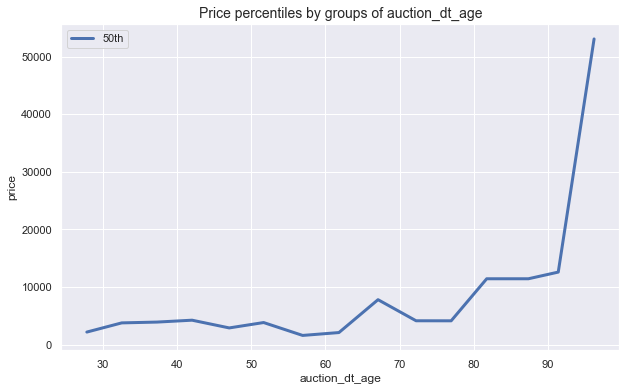

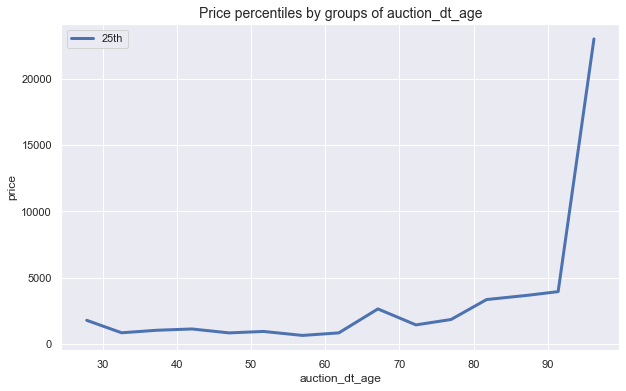

In [7]:
alive_no_na = alive.dropna(subset=['auction_dt_age', 'winning_bid'])  # drop na values

age_bins = np.arange(25, 105, 5)

price_percentiles_by_gr(alive_no_na, age_bins, 'auction_dt_age', percentiles_list=[75, 50, 25])
price_percentiles_by_gr(alive_no_na, age_bins, 'auction_dt_age', percentiles_list=[50])
price_percentiles_by_gr(alive_no_na, age_bins, 'auction_dt_age', percentiles_list=[25])

**Comment:** There seems to be no relationship between age and price for artists younger than 60. After that, increasing...

In [8]:
# Compute Correlation:

alive_age = alive_no_na.auction_dt_age
alive_price = alive_no_na.winning_bid

age_price_Pearson = alive_age.corr(alive_price, method='pearson')
age_price_Spearman = alive_age.corr(alive_price, method='spearman')

print("Pearson correlation between age and price:", age_price_Pearson)
print("Spearman correlation between age and price:", age_price_Spearman)

# Correlation for ages >= 60:

geq_60 = alive_no_na.loc[alive_no_na.auction_dt_age >= 60].copy()
geq_60_age = geq_60.auction_dt_age
geq_60_price = geq_60.winning_bid

geq_60_Pearson = geq_60_age.corr(geq_60_price, method='pearson')
geq_60_Spearman = geq_60_age.corr(geq_60_age, method='spearman')

print("\nPearson correlation (age >= 60):", geq_60_Pearson)
print("Spearman correlation (age >= 60):", geq_60_Spearman)

Pearson correlation between age and price: 0.13980955651578839
Spearman correlation between age and price: 0.2367456435215643

Pearson correlation (age >= 60): 0.161790729284213
Spearman correlation (age >= 60): 1.0


**Comment**: The Spearman correlation for ages greater than or equal to 60 is 1.0, which means that age and price are strongly correlated...

In [15]:
# Run regression:

def summarize_results(results, formula):
    Rsquared = results.rsquared
    print("R^2 = {}".format(Rsquared))
    
    inter = results.params['Intercept']
    print("Intercept = {}".format(inter))
    
    de_var = formula.split('~')[0].strip() # dependent var
    ind_vars = formula.split('~')[1].split(' + ') # indepedent vars
    ind_vars = list(map(str.strip, ind_vars))
    
    exp_formula = '{} = '.format(de_var)
        
    for i, var in enumerate(ind_vars):
        var_slope = results.params[var]
        print("{var} = {slope}".format(var=var, slope=var_slope))
        
        if i == 0:
            exp_formula += '{slope}*{var}'.format(slope=var_slope, var=var)
            continue
            
        exp_formula += ' + {slope}*{var}'.format(slope=var_slope, var=var)
        
    exp_formula += ' + {}'.format(inter)
    print('---')
    print(exp_formula)

age_price_formula = 'winning_bid ~ auction_dt_age' 
age_price_model = smf.ols(age_price_formula, data=alive) 
age_price_results = age_price_model.fit() 

summarize_results(age_price_results, age_price_formula)

R^2 = 0.019546712093141516
Intercept = -12574.411704596405
auction_dt_age = 619.9963306225161
---
winning_bid = 619.9963306225161*auction_dt_age + -12574.411704596405


In [16]:
# Regression for ages >= 60:
geq_60_formula = 'winning_bid ~ auction_dt_age' 
geq_60_model = smf.ols(geq_60_formula, data=geq_60) 
geq_60_results = geq_60_model.fit() 

geq_60_results.params['auction_dt_age']

summarize_results(geq_60_results, geq_60_formula)

R^2 = 0.026176240082317448
Intercept = -112833.45659453902
auction_dt_age = 1864.1270396726713
---
winning_bid = 1864.1270396726713*auction_dt_age + -112833.45659453902


---
# Price and Size

(0, 30000)

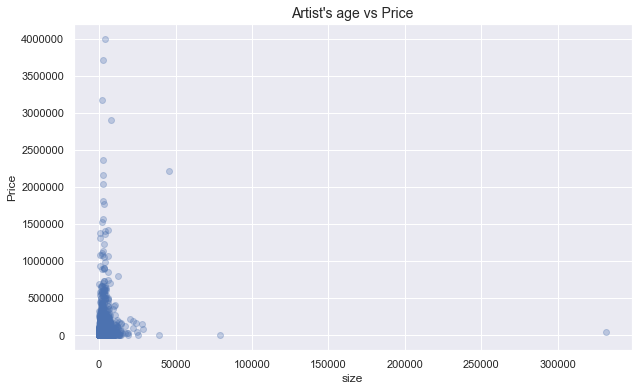

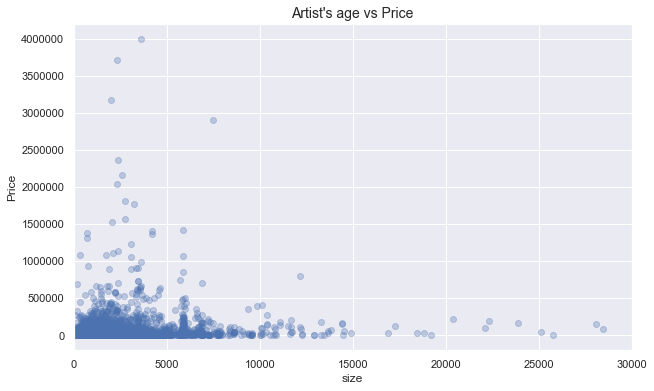

In [11]:
area_vol = saffronart_df.area_or_vol 

scatter_price(area_vol, price, 'size', price_lim=None)

scatter_price(area_vol, price, 'size', price_lim=None)
plt.xlim((0, 30000))

In [12]:
min_av = saffronart_df.area_or_vol.min()
print("Min area/volume: ", min_av)

max_av = saffronart_df.area_or_vol.max()
print("Max area/volume: ", max_av)

Min area/volume:  1.1
Max area/volume:  331776.0


<Figure size 1440x432 with 0 Axes>

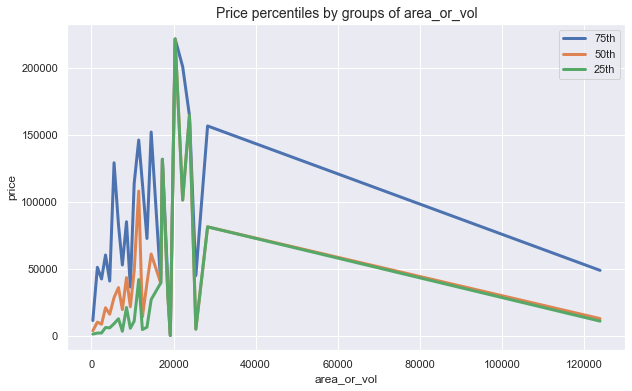

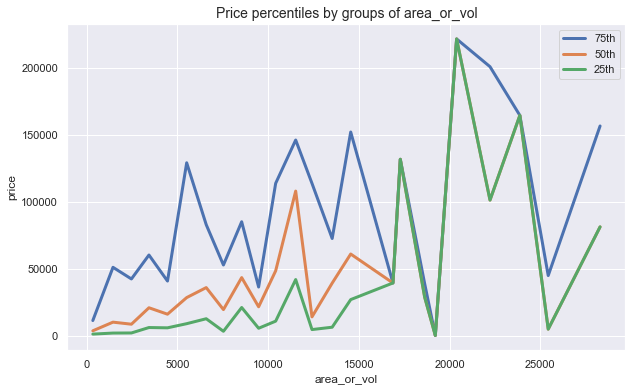

In [13]:
area_vol_bins = np.arange(0, 30000, 1000)

avail_prices = saffronart_df.loc[saffronart_df.winning_bid.notnull()]
less_30k = avail_prices.loc[avail_prices.area_or_vol<30000].copy()


plt.figure(figsize = (20, 6))

price_percentiles_by_gr(avail_prices, area_vol_bins, 'area_or_vol')
price_percentiles_by_gr(less_30k, area_vol_bins, 'area_or_vol')